In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from resources.tokTT import CommentTokenizer as CT
from resources.basicIO import InputOutput as IO
from resources.filterLang import FilterLanguage as FL
from resources.expansion import Expand_U
from resources.fasttext_transformer import classify
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import fasttext
from scipy import spatial
from scipy.spatial import distance
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import LassoLars
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
import copy
import scipy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay


[nltk_data] Downloading package wordnet to C:\Users\AJAY
[nltk_data]     BISWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
model_2 = fasttext.load_model("models/ft_unsupervised_N_2.bin")
model_3 = fasttext.load_model("models/ft_unsupervised_N_3.bin")


In [3]:
df_sample = pd.read_csv("datasets/random_sample_data.csv")
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample['label'].value_counts()


0    1846
1    1408
Name: label, dtype: int64

In [4]:
X_raw = df_sample['tokenized_comment']
y = df_sample['label']

X_2 = [model_2[x] for x in X_raw]
X_3 = [model_3[x] for x in X_raw]


In [18]:
# modify here to change models
X = X_3
model = model_3
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=25,
                                                    stratify=y)


In [19]:
print(len(X_train))
print(len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())


2603
651
0    1477
1    1126
Name: label, dtype: int64
0    369
1    282
Name: label, dtype: int64


In [20]:
N_SAMPLES = 1000

classifiers = {
    "SVM": make_pipeline(StandardScaler(), svm.SVC(probability=True, kernel='rbf')),
    "KNN" : KNeighborsClassifier(n_neighbors=20),
    "LR": make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', penalty='l2', C=0.05, max_iter=10000, random_state=2))
}


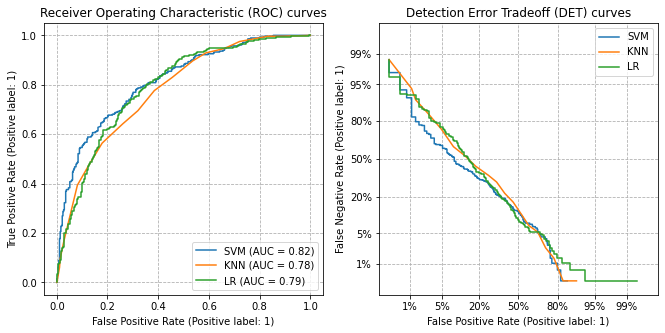

In [21]:
# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig('outputs/figures/' + 'ROC_DET_Normal_N3',
            dpi=300, bbox_inches='tight')
plt.show()


## AL

In [22]:
X_seed, X_expand, y_seed, y_expand = train_test_split(X_train,
                                                      y_train, test_size=0.99,
                                                      random_state=41,
                                                      stratify=y_train)

In [23]:
X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                  classifiers["LR"],
                                                                                  list(
                                                                                      X_seed),
                                                                                  list(
                                                                                      y_seed),
                                                                                  list(
                                                                                      X_expand),
                                                                                  list(
                                                                                      y_expand),
                                                                                  20,
                                                                                  5
                                                                                  )


In [24]:
print('X_seed: ',len(X_seed))
print('X_expand: ',len(X_expand))
y_seed.value_counts()


X_seed:  26
X_expand:  2577


0    15
1    11
Name: label, dtype: int64

In [25]:
print(len(X_uncertain_exp_u))

666


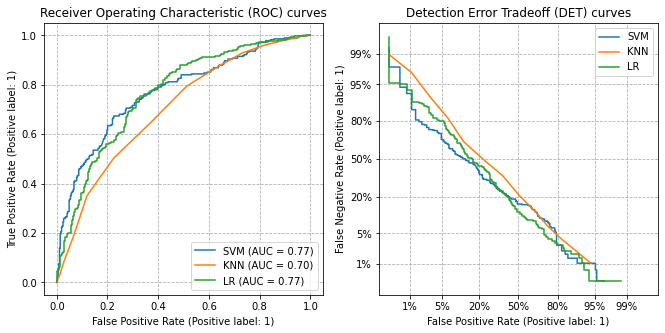

In [26]:
# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_uncertain_exp_u, y_uncertain_exp_u)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig('outputs/figures/' + 'ROC_DET_AL_LR_N3',
            dpi=300, bbox_inches='tight')
plt.show()


In [27]:
X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                  classifiers["SVM"],
                                                                                  list(
                                                                                      X_seed),
                                                                                  list(
                                                                                      y_seed),
                                                                                  list(
                                                                                      X_expand),
                                                                                  list(
                                                                                      y_expand),
                                                                                  20,
                                                                                  5
                                                                                  )


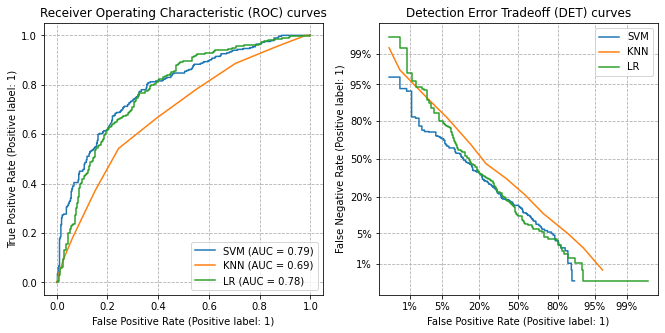

In [28]:
# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_uncertain_exp_u, y_uncertain_exp_u)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig('outputs/figures/' + 'ROC_DET_AL_SVM_N3',
            dpi=300, bbox_inches='tight')
plt.show()


In [29]:
X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                  classifiers["KNN"],
                                                                                  list(
                                                                                      X_seed),
                                                                                  list(
                                                                                      y_seed),
                                                                                  list(
                                                                                      X_expand),
                                                                                  list(
                                                                                      y_expand),
                                                                                  20,
                                                                                  5
                                                                                  )

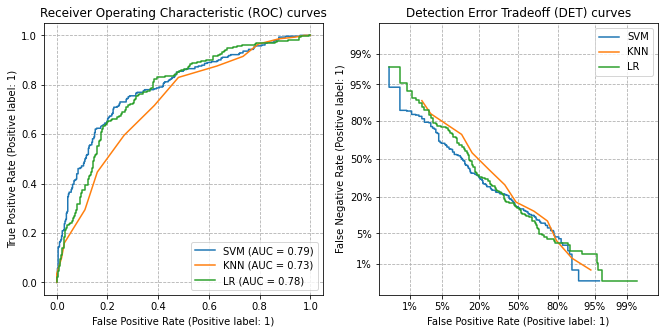

In [30]:
# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_uncertain_exp_u, y_uncertain_exp_u)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.savefig('outputs/figures/' + 'ROC_DET_AL_KNN_N3',
            dpi=300, bbox_inches='tight')
plt.show()
